Daniel Diamont (dd28977)
John Sigmon (jsjs85773)

In [71]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import sklearn as sk

# algorithms and helpers
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import skew
from scipy.stats import pearsonr
from pandas.plotting import scatter_matrix
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# <p style="text-align: center;">EE 461P: Data Science Principles</p>
# <p style="text-align: center;">Assignment 3</p>
## <p style="text-align: center;">Total points: 75</p>
## <p style="text-align: center;">Due: Thursday, October 25th, submitted via Canvas by 11:59 pm</p>

Your homework should be written in a **Jupyter notebook**. You may work in groups of two if you wish. Only one student per team needs to submit the assignment on Canvas.  **Please include the name and UTEID for both students on all submitted files (including this notebook).** In addition, please convert **your filename including your EID** (ex. ss324.jpynb or ss324_mj345.jpypb).

Also, please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting. (%matplotlib inline)

# Question 1a - Stochastic Gradient Descent (25pts)

1. (4pts) Using stochastic gradient descent, derive the coefficent updates for all 4 coefficients of the model: $$ y = w_0 + w_1x_1 + w_2x_1^2 + w_3x_1x_2 $$ Hint: start from the cost function (Assume sum of squared error). If you write the math by hand, include the image in your notebook.

# TODO

2. (12pts) Write Python code for an SGD solution to the non-linear model $$ y = w_0 + w_1x_1 + w_2x_1^2 + w_3x_1x_2$$ Try to format similarly to scikit-learn's models. Your class should take as input the learning_rate, regularization_constant and number of epochs. The fit method must take as input X,y and a choice of update_rule as 'sgd' or 'sgd_momentum' or 'rmsprop'(Notes on implementation below). The _predict_ method takes an X value (optionally, an array of values). Use your new gradient descent regression to predict the data given in 'samples.csv', for 15 epochs, using learning rates: [.0001, .001, .01, 0.1, 1, 10, 100] and regularization constants in the range: [0,10,100] . Plot MSE and the $w$ parameters as a function of epoch (for 15 epochs) for the best 2 combinations of learning_rate and regularization for SGD, SGD-Momentum and RMSProp. I.e., you should have one plot of MSE and another for the parameter updates for SGD, SGD-Momentum and RMSProp (6 plots total).

In [72]:
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error

class SGD(BaseEstimator):
    
    def __init__(self, learning_rate=0.0001, Lambda=0, epochs=100):
        self.learning_rate = learning_rate
        self.Lambda = Lambda
        self.epochs = epochs
    
    def fit(self, data, label, update_rule='sgd'):
        """
        fit takes in data, label, and an update rule.
        Args:
            data   (np.ndarray): Must be randomly loaded from data set to be SGD
            label  (np.ndarray): Target labels
            update_rule (string): 
        """
        # center data
        data = (data-data.mean())/data.std()
        label = (label-label.mean())/label.std()
        W = np.random.uniform(size=(data.shape[1],))
        W = W.reshape(1,-1)
        velocity = (np.zeros((data.shape[1],))).reshape(1,-1)
        self.update_rule = update_rule
        self.data = data
        self.label = label
        mse_hist = []
        W0_hist = []
        W1_hist = []
        
        for epoch in np.arange(0, self.epochs):
            mse = []
            W_epoch0 = np.zeros(data.shape[0],)
            W_epoch1 = np.zeros(data.shape[0],)
            i = 0
            for (batchX, batchY) in self.next_batch(data, label):
                pred = self.sigmoid((np.dot(batchX, W.T)))
                error = mean_squared_error(pred,batchY)
                loss = (error) + self.Lambda*(np.dot(W, W.T))
                mse.append(error)             
                gradient = (2 * batchX * np.asscalar(np.array(error))) + (2 * self.Lambda * W)
                if(update_rule is 'sgd'):
                    W += -self.learning_rate * gradient
                    W_epoch0[i] = W[0][0]
                    W_epoch1[i] = W[0][1]
                    i = i + 1
                elif(update_rule is 'sgd_momentum'):
                    gradient = np.array(gradient)
                    velocity =  (0.9 * velocity) - (self.learning_rate * gradient)
                    W += velocity
                    W_epoch0[i] = W[0][0]
                    W_epoch1[i] = W[0][1]
                    i = i + 1
                elif(update_rule is 'rmsprop'):
                    gradient = np.array(gradient)
                    velocity = (0.9 * velocity) + (0.1 * np.dot(gradient, gradient.T))
                    delta_W = (self.learning_rate * gradient)/(np.sqrt(velocity + 1e-6))
                    W = W - delta_W
                    W_epoch0[i] = W[0][0]
                    W_epoch1[i] = W[0][1]
                    i = i + 1
                else:
                    raise ValueError('invalid update rule')
            mse_hist.append(np.array(mse).mean())
            W0_hist.append(W_epoch0.mean())
            W1_hist.append(W_epoch1.mean())
        self.W = W
        self.mse_hist = mse_hist
        self.W0_hist = W0_hist
        self.W1_hist = W1_hist
        return self
        
    def get_params(self, deep=True):
        param_dict = {'learning_rate': self.learning_rate,
                     'Lambda': self.Lambda,
                     'epochs': self.epochs,}
        
        return param_dict
    
    def set_params(self, **param_dict):
        self.learning_rate = param_dict['learning_rate']
        self.Lambda = param_dict['Lambda']
        self.epochs = param_dict['epochs']
        
        return self
    
    def predict(self, X):
        return np.dot(X, self.W.T)
    
    def next_batch(self, X, y):
        for i in np.arange(0, X.shape[0], 1):
            yield (X[i:i + 1], y[i:i + 1])
            
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))

In [73]:
sgd = SGD()

Use your new gradient descent regression to predict the data given in 'samples.csv', for 15 epochs, using learning rates: [.0001, .001, .01, 0.1, 1, 10, 100] and regularization constants in the range: [0,10,100] . Plot MSE and the w parameters as a function of epoch (for 15 epochs) for the best 2 combinations of learning_rate and regularization for SGD, SGD-Momentum and RMSProp. I.e., you should have one plot of MSE and another for the parameter updates for SGD, SGD-Momentum and RMSProp (6 plots total).

In [74]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

samples = pd.read_csv('samples.csv')

samples.head()

,Unnamed: 0,x1,x2,y
0,0,4.697532,1.135251,-18.284819
1,1,-0.324355,1.042443,-0.251914
2,2,-0.982079,4.053857,-2.350819
3,3,2.637966,4.107375,-2.831104
4,4,4.359560,3.727414,-12.663515


In [75]:
samples_X = samples[['x1', 'x2']]
samples_y = samples[['y']]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(samples_X,
                                                    samples_y,
                                                    test_size = 0.2,
                                                    random_state=42)


In [76]:
X_train.shape

(40, 2)

In [77]:
y_train.shape

(40, 1)

In [78]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
r = SGDRegressor()
r.fit(X_train,y_train)
r.coef_

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

array([-0.96229035, -0.80980686])

In [79]:
y_pred = r.predict(X_train)
mean_squared_error(y_pred, y_train)

46.447683311139826

In [80]:
sgd.fit(X_train, y_train)
sgd.W

SGD(Lambda=0, epochs=100, learning_rate=0.0001)

array([[-0.12928575,  0.42097755]])

In [81]:
y_p = sgd.predict(X_train)
mean_squared_error(y_p, y_train)

84.63628520391744

### Grid Search using SGD

In [82]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# output diverges for learning_rate' >= 0.1

parameters = {'learning_rate': [.0001, .001, .01],
              'Lambda':[0, 10, 100],
               'epochs': [15]}

grid = GridSearchCV(sgd, parameters, 
                   cv=5, 
                   scoring='neg_mean_squared_error',
                   verbose=0,
                   refit=True,
                   error_score='raise',)

_ = grid.fit(X_train, y_train, update_rule='sgd')

In [83]:
results = pd.DataFrame(grid.cv_results_)
results = results[['mean_test_score', 'param_learning_rate', 'param_Lambda']]
results = results.sort_values('mean_test_score', ascending=False)
results.iloc[0:2,:]

,mean_test_score,param_learning_rate,param_Lambda
6,-76.607191,0.0001,100
7,-76.934116,0.001,100


In [84]:
best0 = SGD(learning_rate=0.0001, Lambda=100, epochs=15)
best0.fit(X_train, y_train)

best1 = SGD(learning_rate=0.001, Lambda=100, epochs=15)
best1.fit(X_train, y_train)

SGD(Lambda=100, epochs=15, learning_rate=0.0001)

SGD(Lambda=100, epochs=15, learning_rate=0.001)

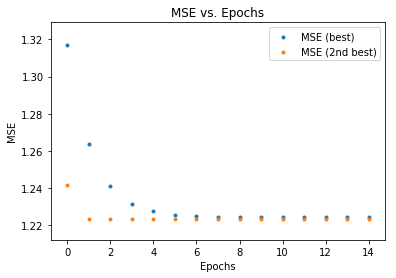

In [85]:
_ = plt.scatter(range(15), best0.mse_hist, label='MSE (best)', marker='.')
_ = plt.scatter(range(15), best1.mse_hist, label='MSE (2nd best)', marker='.')
_ = plt.xlabel("Epochs")
_ = plt.ylabel("MSE")
_ = plt.title("MSE vs. Epochs")
_ = plt.legend()
plt.show()

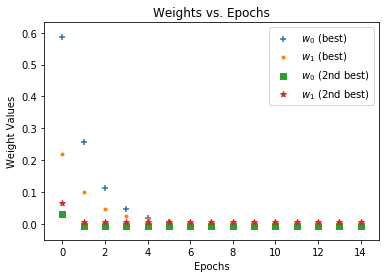

In [86]:
_ = plt.scatter(range(15), best0.W0_hist, label='$ w_0 $ (best)', marker="+")
_ = plt.scatter(range(15), best0.W1_hist, label='$ w_1 $ (best)', marker='.')
_ = plt.scatter(range(15), best1.W0_hist, label='$ w_0 $ (2nd best)', marker=",")
_ = plt.scatter(range(15), best1.W1_hist, label='$ w_1 $ (2nd best)', marker='*')
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Weight Values")
_ = plt.title("Weights vs. Epochs")
_ = plt.legend()
_ = plt.show()

### Grid Search using SGD w/ Momentum

In [87]:
parameters = {'learning_rate': [.0001, .001, .01,],
              'Lambda':[0, 10, 100],
               'epochs': [15]}

grid_momentum = GridSearchCV(sgd, parameters, 
                   cv=5, 
                   scoring='neg_mean_squared_error',
                   verbose=0,
                   refit=True,
                   error_score='raise',)

_ = grid_momentum.fit(X_train, y_train, update_rule='sgd_momentum')

In [88]:
results = pd.DataFrame(grid_momentum.cv_results_)
results = results[['mean_test_score', 'param_learning_rate', 'param_Lambda']]
results = results.sort_values('mean_test_score', ascending=False)
results.iloc[0:2,:]

,mean_test_score,param_learning_rate,param_Lambda
6,-76.569620,0.0001,100
7,-76.779181,0.001,100


In [89]:
best0_mom = SGD(learning_rate=0.0001, Lambda=100, epochs=15)
best0_mom.fit(X_train, y_train, update_rule='sgd_momentum')

best1_mom = SGD(learning_rate=0.001, Lambda=100, epochs=15)
best1_mom.fit(X_train, y_train, update_rule='sgd_momentum')

SGD(Lambda=100, epochs=15, learning_rate=0.0001)

SGD(Lambda=100, epochs=15, learning_rate=0.001)

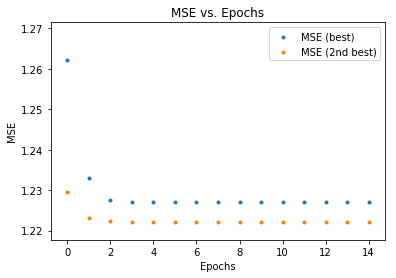

In [90]:
_ = plt.scatter(range(15), best0_mom.mse_hist, label='MSE (best)', marker='.')
_ = plt.scatter(range(15), best1_mom.mse_hist, label='MSE (2nd best)', marker='.')
_ = plt.xlabel("Epochs")
_ = plt.ylabel("MSE")
_ = plt.title("MSE vs. Epochs")
_ = plt.legend()
plt.show()

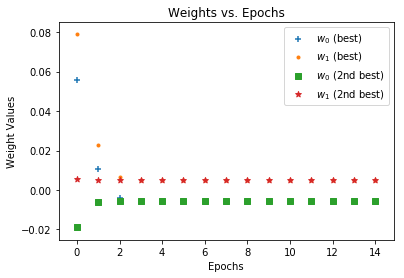

In [91]:
_ = plt.scatter(range(15), best0_mom.W0_hist, label='$ w_0 $ (best)', marker="+")
_ = plt.scatter(range(15), best0_mom.W1_hist, label='$ w_1 $ (best)', marker='.')
_ = plt.scatter(range(15), best1_mom.W0_hist, label='$ w_0 $ (2nd best)', marker=",")
_ = plt.scatter(range(15), best1_mom.W1_hist, label='$ w_1 $ (2nd best)', marker='*')
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Weight Values")
_ = plt.title("Weights vs. Epochs")
_ = plt.legend()
_ = plt.show()

### Grid Search using RMSprop

In [92]:
parameters = {'learning_rate': [.0001, .001, .01, 0.1, 1, 100],
              'Lambda':[0, 10, 100],
               'epochs': [15]}

grid_rmsprop = GridSearchCV(sgd, parameters, 
                   cv=5, 
                   scoring='neg_mean_squared_error',
                   verbose=0,
                   refit=True,
                   error_score='raise',)

_ = grid_rmsprop.fit(X_train, y_train, update_rule='rmsprop')

In [93]:
results = pd.DataFrame(grid_rmsprop.cv_results_)
results = results[['mean_test_score', 'param_learning_rate', 'param_Lambda']]
results = results.sort_values('mean_test_score', ascending=False)
results.iloc[0:2,:]

,mean_test_score,param_learning_rate,param_Lambda
14,-76.870774,0.01,100
8,-77.370646,0.01,10


In [94]:
best0_rms = SGD(learning_rate=1, Lambda=100, epochs=15)
best0_rms.fit(X_train, y_train, update_rule='rmsprop')

best1_rms = SGD(learning_rate=0.01, Lambda=100, epochs=15)
best1_rms.fit(X_train, y_train, update_rule='rmsprop')

SGD(Lambda=100, epochs=15, learning_rate=1)

SGD(Lambda=100, epochs=15, learning_rate=0.01)

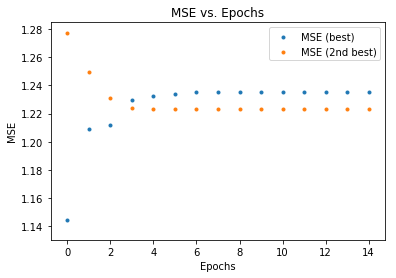

In [95]:
_ = plt.scatter(range(15), best0_rms.mse_hist, label='MSE (best)', marker='.')
_ = plt.scatter(range(15), best1_rms.mse_hist, label='MSE (2nd best)', marker='.')
_ = plt.xlabel("Epochs")
_ = plt.ylabel("MSE")
_ = plt.title("MSE vs. Epochs")
_ = plt.legend()
plt.show()

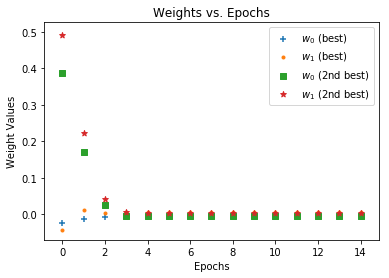

In [96]:
_ = plt.scatter(range(15), best0_rms.W0_hist, label='$ w_0 $ (best)', marker="+")
_ = plt.scatter(range(15), best0_rms.W1_hist, label='$ w_1 $ (best)', marker='.')
_ = plt.scatter(range(15), best1_rms.W0_hist, label='$ w_0 $ (2nd best)', marker=",")
_ = plt.scatter(range(15), best1_rms.W1_hist, label='$ w_1 $ (2nd best)', marker='*')
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Weight Values")
_ = plt.title("Weights vs. Epochs")
_ = plt.legend()
_ = plt.show()

 4. (2pts) Report the MSE at the end of 15 epochs for both combinations.

###### Vanilla SGD

In [97]:
print("For learning_rate={} and Lambda={}".format(best0.learning_rate, best0.Lambda))
pred = best0.predict(X_train)
print("MSE = {:.5f}".format(mean_squared_error(y_train, pred)))

print("For learning_rate={} and Lambda={}".format(best1.learning_rate, best1.Lambda))
pred = best1.predict(X_train)
print("MSE = {:.5f}".format(mean_squared_error(y_train, pred)))



For learning_rate=0.0001 and Lambda=100
MSE = 76.52615
For learning_rate=0.001 and Lambda=100
MSE = 76.88421


###### SGD with momentum

In [98]:
print("For learning_rate={} and Lambda={}".format(best0_mom.learning_rate, best0_mom.Lambda))
pred = best0_mom.predict(X_train)
print("MSE = {:.5f}".format(mean_squared_error(y_train, pred)))

print("For learning_rate={} and Lambda={}".format(best1_mom.learning_rate, best1_mom.Lambda))
pred = best1_mom.predict(X_train)
print("MSE = {:.5f}".format(mean_squared_error(y_train, pred)))

For learning_rate=0.0001 and Lambda=100
MSE = 76.55004
For learning_rate=0.001 and Lambda=100
MSE = 76.87586


###### RMSProp

In [99]:
print("For learning_rate={} and Lambda={}".format(best0_rms.learning_rate, best0_rms.Lambda))
pred = best0_rms.predict(X_train)
print("MSE = {:.5f}".format(mean_squared_error(y_train, pred)))

print("For learning_rate={} and Lambda={}".format(best1_rms.learning_rate, best1_rms.Lambda))
pred = best1_rms.predict(X_train)
print("MSE = {:.5f}".format(mean_squared_error(y_train, pred)))



For learning_rate=1 and Lambda=100
MSE = 79.47900
For learning_rate=0.01 and Lambda=100
MSE = 76.81274


5. (3pts) Based on the experiments, which of the 3 techniques allowed for larger initial setting of the learning_rate? Why?


RMS prop allowed for the largest initial setting of the learning rate because it is the method which most dampens any oscillations during gradient descent.

In this particular case, the momentum was not enough to dampen the oscillations as the learning rate increased, but the moving average of rmsprop was enough and allowed the algorithm to converge at higher learning rates.

6. Now consider the following 2x2x1 network with one hidden layer. The input layer has two nodes, and the output layer has one node.

# TODO

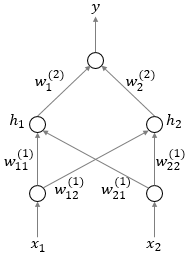

Both hidden layer units use a *sigmoid* activation function, and the output unit uses an identity activation (i.e. the output is just a weighted sum of the inputs).

(a) (2pts) Write the output $y$ as a function of the inputs $x_1$ and $x_2$.

(b) (2pts) Derive the update rule for the layer-one weight $w_{12}^{(1)}$.

# Notes on SGD with momentum
Momentum helps accelerate SGD in relevant direction and dampens the oscillations. It tries to maintain the direction in which the gradient vector was already pointing and adjusts the direction slowly with the new gradients. The steps can be listed below :
1. v[t] = mu * v[t-1] - (learning_rate)*(gradient)
2. w = w + v

Set mu = 0.90. Initialize v with zeros.


# Notes on RMSProp
RMSProp (http://ruder.io/optimizing-gradient-descent/) differs from vanilla SGD in that the learning rate of each weight changes over updates. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate.  In particular, it uses a moving average of squared gradients as cache. The learning_rate is divided by the cache, resulting in a different learning rate for each weight. A consequence of this update rule is that weights that have already seen large gradients (made large jumps) make smaller updates in subsequent iterations.
Specifically, the steps can be listed as below:
1. cache = (decay_rate)*(cache) + (1 - decay_rate)*(gradients^2) 
2. weights = weights - ((learning_rate)/sqrt(cache+1e-6))*gradients

Use decay_rate = 0.90. Initialize cache with zeros.

# (Optional) Notes on Training with Gradient Descent
1. Compute error: This consists of a prediction error and a regularization term. From an implementation perspective, this is a function that takes as input the truth, prediction and regularization hyperparameter and returns an error
2. Compute gradients: Take a derivative of the error in terms of the weights. This can be modelled as a function that takes as input the error and features and returns the gradients for each weight
3. Update weights: Weight updates can be done using vanilla SGD or adaptive techniques. The update function takes as inputs the gradient and hyperparameters and returns the new weights.

# Question 2 - Multi-layer perceptron Regressor (15 pts)

In this question, you will explore the application of Multi-layer Perceptron (MLP) regression using sklearn package in Python;
http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html.


We will use the OpenCL gemm kernel performance prediction dataset for this problem; https://archive.ics.uci.edu/ml/datasets/SGEMM+GPU+kernel+performance.

Following code will pre-process the data and split the data into training and test set using [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with **random state 30** and **test_size = 0.25**.

In [100]:
%reset
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,KFold)
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [101]:
%%sh
curl https://archive.ics.uci.edu/ml/machine-learning-databases/00440/sgemm_product_dataset.zip > data.zip
unzip data.zip
rm data.zip
rm Readme.txt
rm -rf __MACOSX

Archive:  data.zip
  inflating: Readme.txt              
   creating: __MACOSX/
  inflating: __MACOSX/._sgemm_product.csv  


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3111k  100 3111k    0     0  2234k      0  0:00:01  0:00:01 --:--:-- 2233k
replace sgemm_product.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [102]:
data = pd.read_csv('sgemm_product.csv') 
data['target'] = 0.25*(data['Run1 (ms)'] + data['Run2 (ms)']+ data['Run3 (ms)'] + data['Run4 (ms)'])
y = data['target']
y = y.as_matrix()
X = data.drop(['target','Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=30)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(181200, 14) (181200,) (60400, 14) (60400,)


One more thing to use in this problem is [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Instead of fitting a model on original data, use StandardScaler to make each feature centered ([Example](http://scikit-learn.org/stable/auto_examples/applications/plot_prediction_latency.html#sphx-glr-auto-examples-applications-plot-prediction-latency-py)). Whenever you have training and test data, fit a scaler on training data and use this scaler on test data. Here, scale only features (independent variables), not target variable y. 

1) (5pts) Use [sklearn.neural_nework.MLPRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) to do a 5-fold cross validation using sklearn's [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold). The cross validation must be performed on the **training data**. Use following parameter settings for MLPRegressor:

    activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42,
    batch_size=30, learning_rate_init = 0.005
    
   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for each model.

In [103]:
scaler = StandardScaler()
Xs = pd.DataFrame(scaler.fit_transform(X), columns=X.columns.values)

    (a) *hidden_layer_sizes = (2,)* 

In [104]:
k_fold = KFold(5)

mse = []

for k, (train_index, test_index) in enumerate(k_fold.split(Xs, y)):

    net = MLPRegressor(hidden_layer_sizes=(2,), 
                       activation = 'tanh', 
                       solver = 'sgd', 
                       learning_rate='constant', 
                       random_state=42,
                       batch_size=30, 
                       learning_rate_init = 0.005)
    
    _ = net.fit(Xs.iloc[train_index], y[train_index])
    y_pred = net.predict(Xs.iloc[test_index])
    mse.append(np.sqrt(mean_squared_error(y[test_index], y_pred)))

min_mse = np.amin(mse)
print(min_mse)

103.32329087956309


    (b) *hidden_layer_sizes = (10,)*

In [105]:
k_fold = KFold(5)

mse = []

for k, (train_index, test_index) in enumerate(k_fold.split(Xs, y)):

    net = MLPRegressor(hidden_layer_sizes=(10,), 
                       activation = 'tanh', 
                       solver = 'sgd', 
                       learning_rate='constant', 
                       random_state=42,
                       batch_size=30, 
                       learning_rate_init = 0.005)
    
    _ = net.fit(Xs.iloc[train_index], y[train_index])
    y_pred = net.predict(Xs.iloc[test_index])
    mse.append(np.sqrt(mean_squared_error(y[test_index], y_pred)))

min_mse = np.amin(mse)
print(min_mse)

111.94833020804597


    (c) *hidden_layer_sizes = (30,)*

In [106]:
k_fold = KFold(5)

mse = []

for k, (train_index, test_index) in enumerate(k_fold.split(Xs, y)):

    net = MLPRegressor(hidden_layer_sizes=(30,), 
                       activation = 'tanh', 
                       solver = 'sgd', 
                       learning_rate='constant', 
                       random_state=42,
                       batch_size=30, 
                       learning_rate_init = 0.005)
    
    _ = net.fit(Xs.iloc[train_index], y[train_index])
    y_pred = net.predict(Xs.iloc[test_index])
    mse.append(np.sqrt(mean_squared_error(y[test_index], y_pred)))

min_mse = np.amin(mse)
print(min_mse)

136.38368507513923


    (d) *hidden_layer_sizes = (50,)*

In [107]:
k_fold = KFold(5)

mse = []

for k, (train_index, test_index) in enumerate(k_fold.split(Xs, y)):

    net = MLPRegressor(hidden_layer_sizes=(50,), 
                       activation = 'tanh', 
                       solver = 'sgd', 
                       learning_rate='constant', 
                       random_state=42,
                       batch_size=30, 
                       learning_rate_init = 0.005)
    
    _ = net.fit(Xs.iloc[train_index], y[train_index])
    y_pred = net.predict(Xs.iloc[test_index])
    mse.append(np.sqrt(mean_squared_error(y[test_index], y_pred)))

min_mse = np.amin(mse)
print(min_mse)

110.80003724618017


2) (5pts) Now, using the same parameters used in part 1), train MLPRegressor models on the entire training set and report the RMSE score for both the trainnig and testing sets (again, use StandardScaler). Which of the four models ((a)-(d)) performs the best? Briefly analyze and discuss the results, commenting on the number of hidden units.

In [108]:
scaler = StandardScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns.values)
X_test_s = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns.values)

In [109]:
net = MLPRegressor(hidden_layer_sizes=(2,), 
                       activation = 'tanh', 
                       solver = 'sgd', 
                       learning_rate='constant', 
                       random_state=42,
                       batch_size=30, 
                       learning_rate_init = 0.005)

_ = net.fit(X_train_s, y_train)
pred = net.predict(X_train_s)
test_pred = net.predict(X_test_s)
print("MSE (train ): {:.5f}".format(np.sqrt(mean_squared_error(y_train, pred))))
print("MSE ( test ): {:.5f}".format(np.sqrt(mean_squared_error(y_test, test_pred))))

MSE (train ): 234.71824
MSE ( test ): 230.42213


In [110]:
net = MLPRegressor(hidden_layer_sizes=(10,), 
                       activation = 'tanh', 
                       solver = 'sgd', 
                       learning_rate='constant', 
                       random_state=42,
                       batch_size=30, 
                       learning_rate_init = 0.005)

_ = net.fit(X_train_s, y_train)
pred = net.predict(X_train_s)
test_pred = net.predict(X_test_s)
print("RMSE (train ): {:.5f}".format(np.sqrt(mean_squared_error(y_train, pred))))
print("RMSE ( test ): {:.5f}".format(np.sqrt(mean_squared_error(y_test, test_pred))))

RMSE (train ): 207.92180
RMSE ( test ): 205.94493


In [111]:
net = MLPRegressor(hidden_layer_sizes=(30,), 
                       activation = 'tanh', 
                       solver = 'sgd', 
                       learning_rate='constant', 
                       random_state=42,
                       batch_size=30, 
                       learning_rate_init = 0.005)

_ = net.fit(X_train_s, y_train)
pred = net.predict(X_train_s)
test_pred = net.predict(X_test_s)
print("RMSE (train ): {:.5f}".format(np.sqrt(mean_squared_error(y_train, pred))))
print("RMSE ( test ): {:.5f}".format(np.sqrt(mean_squared_error(y_test, test_pred))))

RMSE (train ): 167.83977
RMSE ( test ): 164.97924


In [112]:
net = MLPRegressor(hidden_layer_sizes=(50,), 
                       activation = 'tanh', 
                       solver = 'sgd', 
                       learning_rate='constant', 
                       random_state=42,
                       batch_size=30, 
                       learning_rate_init = 0.005)

_ = net.fit(X_train_s, y_train)
pred = net.predict(X_train_s)
test_pred = net.predict(X_test_s)
print("RMSE (train ): {:.5f}".format(np.sqrt(mean_squared_error(y_train, pred))))
print("RMSE ( test ): {:.5f}".format(np.sqrt(mean_squared_error(y_test, test_pred))))

RMSE (train ): 172.16489
RMSE ( test ): 169.35345


The models perfomed in the following order:

50 hidden units >> 20 hidden units >> 30 hidden units >> 2 hidden units

    (where the best was the 50 hidden unit model and the worst was the 2 hidden unit model)
    
The error on both the training and test sets decreased as the number of hidden units increased, suggesting that the model with the 2 hidden units had underfit to the data with comparison to the rest of the models. It is unclear why the 20 hidden unit model performed better than the 30 hidden unit model. However, the 50 hidden unit model fit very well to the training data and generalized very well too. The takeaway here is that increasing the number of hidden units increases the complexity of our model. Because of this, we must be careful about the number of hidden units that we select for a problem. Too many units and we overfit; too little units and we underfit.

3) (5pts) MLPRegressor has a built-in attribute *loss\_curve\_* which returns the loss at each epoch (misleadingly referred to as "iteration" in scikit documentation, though they use epoch in the actual code!). For example, if your model is named as *my_model* you can call it as *my\_model.loss\_curve\_* ([example](http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py)). Plot three curves using below conditions (a, b, c) in one figure, where *X-axis* is epoch  number and *Y-axis* is squared root of *loss\_curve\_* valu;:

   (a) *hidden_layer_sizes = (1,)* 


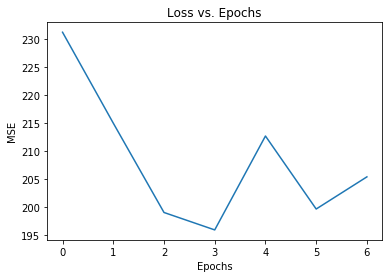

In [113]:
net = MLPRegressor(hidden_layer_sizes=(1,), 
                       activation = 'tanh', 
                       solver = 'sgd', 
                       learning_rate='constant', 
                       random_state=42,
                       batch_size=30, 
                       learning_rate_init = 0.005)

_ = net.fit(X_train_s, y_train)

loss = np.sqrt(net.loss_curve_)
epochs = range(len(loss))

_ = plt.plot(epochs, loss)
_ = plt.title("Loss vs. Epochs")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("MSE")
_ = plt.show()

   (b) *hidden_layer_sizes = (5,)*


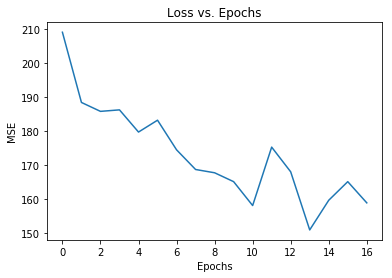

In [114]:
net = MLPRegressor(hidden_layer_sizes=(5,), 
                       activation = 'tanh', 
                       solver = 'sgd', 
                       learning_rate='constant', 
                       random_state=42,
                       batch_size=30, 
                       learning_rate_init = 0.005)

_ = net.fit(X_train_s, y_train)

loss = np.sqrt(net.loss_curve_)
epochs = range(len(loss))

_ = plt.plot(epochs, loss)
_ = plt.title("Loss vs. Epochs")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("MSE")
_ = plt.show()

   (c) *hidden_layer_sizes = (10,)*

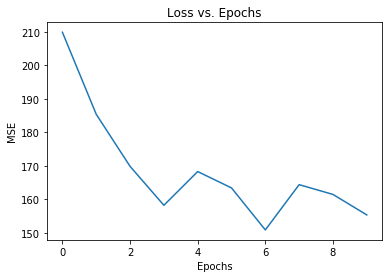

In [115]:
net = MLPRegressor(hidden_layer_sizes=(10,), 
                       activation = 'tanh', 
                       solver = 'sgd', 
                       learning_rate='constant', 
                       random_state=42,
                       batch_size=30, 
                       learning_rate_init = 0.005)

_ = net.fit(X_train_s, y_train)

loss = np.sqrt(net.loss_curve_)
epochs = range(len(loss))

_ = plt.plot(epochs, loss)
_ = plt.title("Loss vs. Epochs")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("MSE")
_ = plt.show()

# Question 3 - [Kaggle Competition] Nomad2018 Predicting Transparent Conductors (25 pts)

In this problem, we are going to explore a Kaggle competition: [Transparent Conductors](https://www.kaggle.com/c/nomad2018-predict-transparent-conductors). Your goal is to obtain the best score you can in this competition.

The first step is to make a Kaggle account. Then find this competition and read the competition details and the description of the dataset. 

Your work should meet the following requirements:

1. Data Preprocessing. 
 * Conduct some data preprocessing. (Hint: see if there is any skewed features and consider applying suitable transformation techniques to make them more "normal").
 * Impute the missing values (if any).
 * Create new features using interactions
2. Predictive Models. 
 * You have to create three models: Lasso regression, Ridge regression, and multilayer perceptron.  For Lasso and Ridge regression, optimize the alphas using cross validation. For the MLP model, you can use one hidden layer. You may try other predictive models to get better scores (optional).
3. Get a score of 0.0800 or lower on the Private Leaderboard. Take a screenshot of your private leaderboard after submission as proof. You can also click My Submissions tab to see the history of your submissions. It will show both Public Leaderboard & Private Leaderboard score.

Briefly describe your work on each of these steps. Explain (very briefly) what approaches you tried, what worked and what did not work. Mention your team's kaggle name and include a screen shot of your public submission score. Finally, try your best to win this competition!

## Answer

### Part 1 Preprocessing

In [116]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [133]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [134]:
%%sh
# Download data and unzip it
# Alternativey place all.zip inside hw3 directory if you don't have Kaggle API installed
#kaggle competitions download -c nomad2018-predict-transparent-conductors 
DATADIR="data"
ls
unzip -d $DATADIR/ all.zip
rm all.zip
cd $DATADIR
unzip test.zip
unzip train.zip
rm *.zip
rm -rf *MACOSX
cd ../

1
data
HW3.ipynb
samples.csv
sgemm_product.csv
test_sol.csv


unzip:  cannot find or open all.zip, all.zip.zip or all.zip.ZIP.
rm: cannot remove 'all.zip': No such file or directory
unzip:  cannot find or open test.zip, test.zip.zip or test.zip.ZIP.
unzip:  cannot find or open train.zip, train.zip.zip or train.zip.ZIP.
rm: cannot remove '*.zip': No such file or directory


In [135]:
data_path = 'data'
train_fname = 'train.csv'
test_fname = 'test.csv'
labels = ['formation_energy_ev_natom', 'bandgap_energy_ev']

In [136]:
train = pd.read_csv(os.path.join(data_path, train_fname))
test = pd.read_csv(os.path.join(data_path, test_fname))

In [137]:
train.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


In [138]:
train_labels = train[labels]
train_data = train.drop(columns=[*labels, 'id'])

In [139]:
test_data = test.drop(columns=['id'])

First check for missing values.

In [140]:
train_data.isnull().values.any()

False

That's weird, check the labels also.

In [141]:
train_labels.isnull().values.any()

False

OK, then let's take a look at the data distributions.

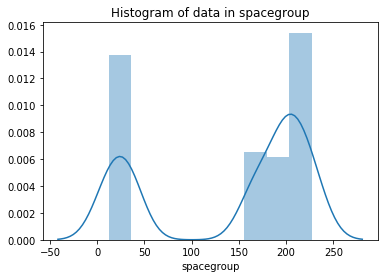

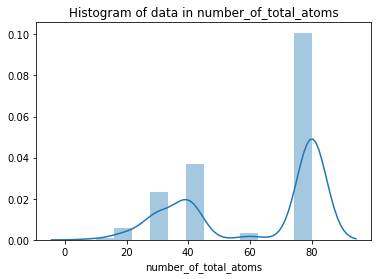

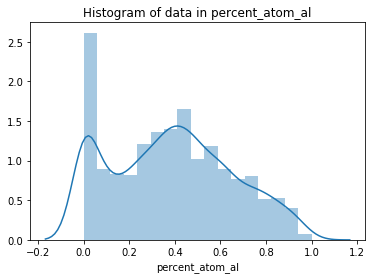

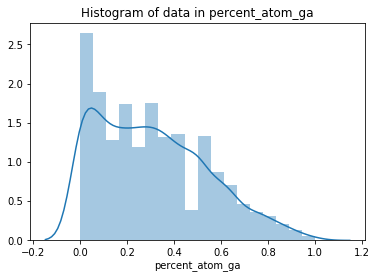

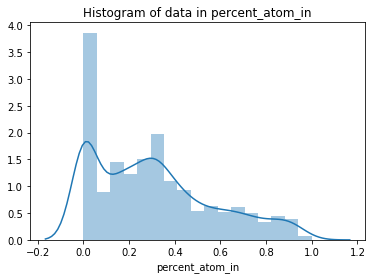

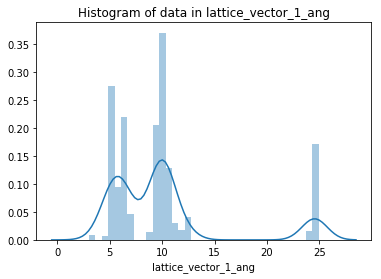

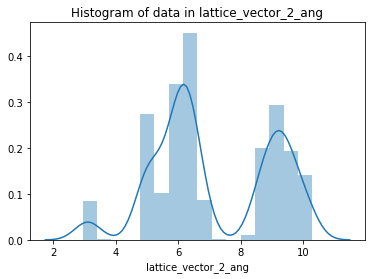

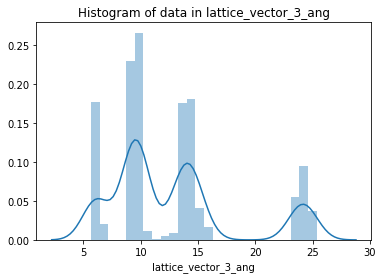

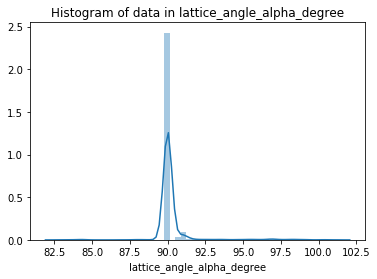

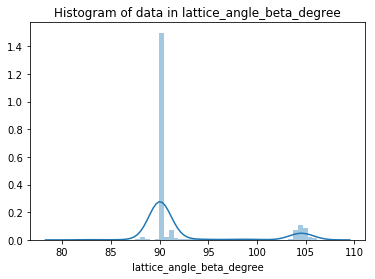

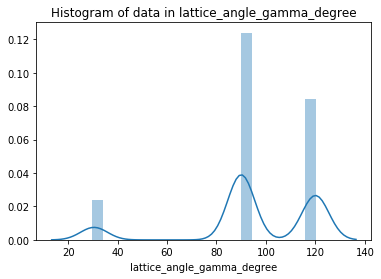

In [142]:
for col in train_data.columns:
    _ = plt.title('Histogram of data in {}'.format(col))
    _ = sns.distplot(train_data[col])
    plt.show()

We are just going to throw all of these columns into the StandardScaler.

In [143]:
scaler = StandardScaler()
_ = scaler.fit(train_data)
train_data = pd.DataFrame(
                        data=scaler.transform(train_data),
                        index=train['id'],
                        columns=train_data.columns
)

scaler = StandardScaler()
_ = scaler.fit(test_data)
test_data = pd.DataFrame(
                        data=scaler.transform(test_data),
                        index=test['id'],
                        columns=test_data.columns
)

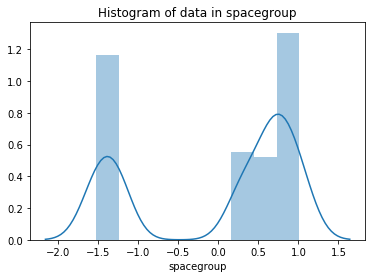

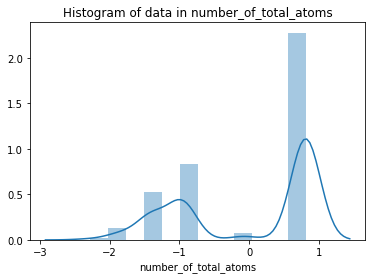

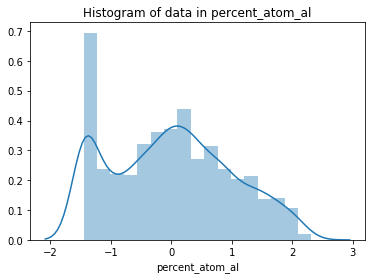

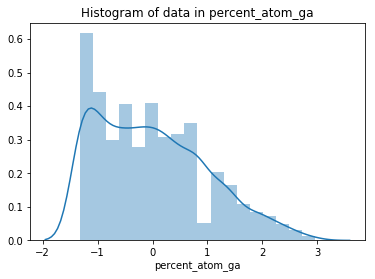

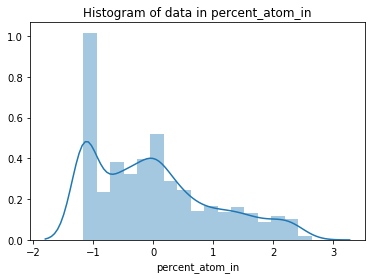

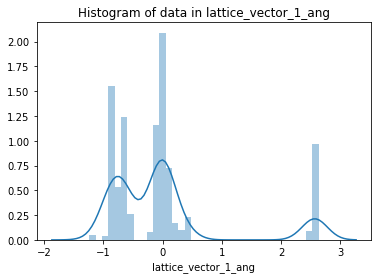

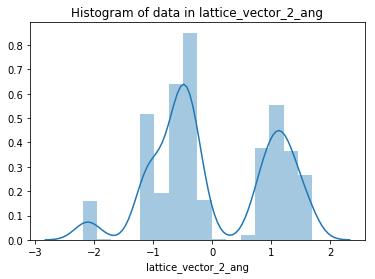

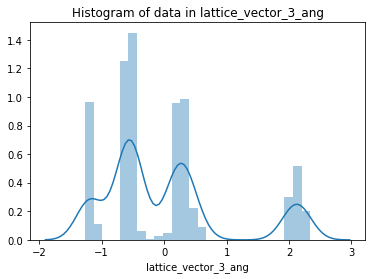

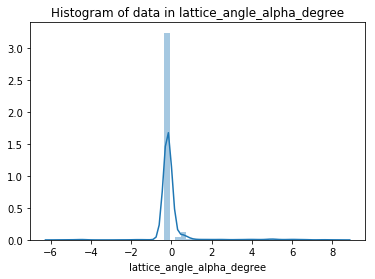

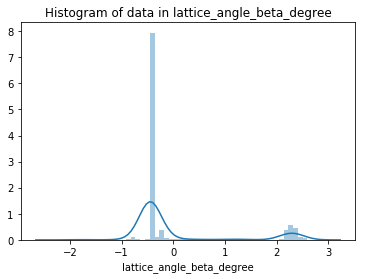

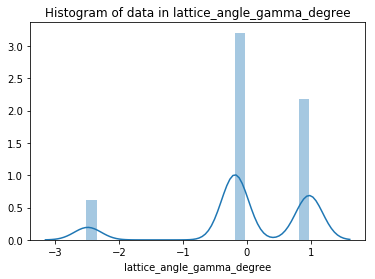

In [144]:
for col in train_data.columns:
    _ = plt.title('Histogram of data in {}'.format(col))
    _ = sns.distplot(train_data[col])
    plt.show()

Looks better, now let's get these atom locations loaded.

In [187]:
%%sh
# lines | words | bytes | filename
wc data/test/1/geometry.xyz
wc data/test/47/geometry.xyz

  86  421 5550 data/test/1/geometry.xyz
  86  421 5603 data/test/47/geometry.xyz


In [188]:
%%sh
head data/test/1/geometry.xyz

#=======================================================
#Created using the Atomic Simulation Environment (ASE)
#=======================================================
lattice_vector 10.5378440999999992 -0.0416559800000000 -0.0546684100000000 
lattice_vector 0.0353999200000000 9.0140084100000006 -0.0275333100000000 
lattice_vector 0.0500609000000000 0.0292891200000000 9.6359329900000006 
atom 1.7089214588200001 7.6848373406700006 6.6842861752599996 In
atom 6.9778435088199995 7.6640093506700007 6.6569519702599997 In
atom 3.6401549557799990 1.3345275526100000 1.8753704028000002 In
atom 8.9090770057800004 1.3136995626100001 1.8480361978000002 In


In [189]:
num_train_data_points = len(train_data)
num_test_data_points = len(test_data)
num_geometry_data_points = 83
size_geometry_data_point = 3

In [190]:
train_data_geometry = np.empty(
    (num_train_data_points, 
     num_geometry_data_points, 
     size_geometry_data_point)
)
test_data_geometry = np.empty(
    (num_train_data_points, 
     num_geometry_data_points, 
     size_geometry_data_point)
)

In [191]:
for data_point in range(num_train_data_points):
    path_to_geometry_file = os.path.join(data_path, 'train', str(data_point + 1))
    with open(path_to_geometry_file + '/geometry.xyz', 'rb') as f:
        lines = f.read().splitlines()
    lines = lines[3:]
    for idx, line in enumerate(lines):
        line = line.split()[1:]
        if len(line) is 4:
            line = line[:-1]
        train_data_geometry[data_point, idx, :] = np.array(line)

for data_point in range(num_test_data_points):
    path_to_geometry_file = os.path.join(data_path, 'test', str(data_point + 1))
    with open(path_to_geometry_file + '/geometry.xyz', 'rb') as f:
        lines = f.read().splitlines()
    lines = lines[3:]
    for idx, line in enumerate(lines):
        line = line.split()[1:]
        if len(line) is 4:
            line = line[:-1]
        test_data_geometry[data_point, idx, :] = np.array(line)

We could do PCA on these vectors, but the weights learned by an autoencoder will span the same subspace as the PCA transformation, and it is non-linear and therefore allows a richer class of functions.

In [192]:
# For Linux, Python 3.5, and no CUDA
!pip3 install http://download.pytorch.org/whl/cpu/torch-0.4.1-cp35-cp35m-linux_x86_64.whl 2&1> /dev/null
!pip3 install torchvision 2&1> /dev/null

In [193]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import functional as F

In [194]:
epochs = 35
batch_size = 256
lr = 0.01
input_size = train_data_geometry.shape[1]*train_data_geometry.shape[2]

class GeometryDataset(Dataset):
    def __init__(self, train_data_geometry):
        self.data = train_data_geometry.reshape(
            len(train_data_geometry), input_size)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
        
dataset = GeometryDataset(train_data_geometry)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8)

In [199]:
model = torch.nn.Sequential(
    torch.nn.Linear(input_size, 3),
    torch.nn.ELU(),
    torch.nn.Linear(3, input_size),
    torch.nn.ELU()
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()
INF = 99999
#stopping_epsilon = 2
#stop = False

early_stopping = [INF]
for _ in range(epochs):
    for i, batch in enumerate(dataloader, 0):
        y_pred = model(batch.float())
        loss = criterion(y_pred, batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #if early_stopping[-1] < loss.data[0] + stopping_epsilon:
    #    early_stopping.append(loss.data[0])
    #    break
    #else:
    #    early_stopping.append(loss.data[0])
    print("Epoch:\t{}\tLoss:\t{}".format(_, loss.data[0]))

Epoch:	0	Loss:	nan
Epoch:	1	Loss:	nan
Epoch:	2	Loss:	nan
Epoch:	3	Loss:	nan
Epoch:	4	Loss:	nan
Epoch:	5	Loss:	nan
Epoch:	6	Loss:	nan
Epoch:	7	Loss:	nan
Epoch:	8	Loss:	nan
Epoch:	9	Loss:	nan
Epoch:	10	Loss:	nan
Epoch:	11	Loss:	nan
Epoch:	12	Loss:	nan
Epoch:	13	Loss:	nan
Epoch:	14	Loss:	nan
Epoch:	15	Loss:	nan
Epoch:	16	Loss:	nan
Epoch:	17	Loss:	nan
Epoch:	18	Loss:	nan
Epoch:	19	Loss:	nan
Epoch:	20	Loss:	nan
Epoch:	21	Loss:	nan
Epoch:	22	Loss:	nan
Epoch:	23	Loss:	nan
Epoch:	24	Loss:	nan
Epoch:	25	Loss:	nan
Epoch:	26	Loss:	nan
Epoch:	27	Loss:	nan
Epoch:	28	Loss:	nan
Epoch:	29	Loss:	nan
Epoch:	30	Loss:	nan
Epoch:	31	Loss:	nan
Epoch:	32	Loss:	nan
Epoch:	33	Loss:	nan
Epoch:	34	Loss:	nan


In [200]:
W = list(model[0].parameters())[0].detach().numpy()
b = list(model[0].parameters())[1].detach().numpy()
print(W.shape)
print(b.shape)

(3, 249)
(3,)


Now lets transform the geometry data and add to the dataframe.

In [176]:
def elu(X, alpha=1):
    return np.where(X < 0, alpha * (np.exp(X) - 1), X)

# Transform training data
features_to_add_train = np.empty((num_train_data_points, 3))
for idx in range(num_train_data_points):
    features_to_add_train[idx] = elu(np.matmul(W, train_data_geometry[idx].flatten()) + b)
    
# Transform test data
features_to_add_test = np.empty((num_test_data_points, 3))
for idx in range(num_test_data_points):
    features_to_add_test[idx] = elu(np.matmul(W, test_data_geometry[idx].flatten()) + b)

In [177]:
del model

In [178]:
features_to_add_train.shape
features_to_add_test.shape

(2400, 3)

(600, 3)

In [179]:
features_to_add_train

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       ...,
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

In [158]:
for idx in range(3):
    train_data['geo-{}'.format(idx)] = features_to_add_train[:, idx]
    test_data['geo-{}'.format(idx)] = features_to_add_test[:, idx]

In [159]:
train_data.columns
test_data.columns

Index(['spacegroup', 'number_of_total_atoms', 'percent_atom_al',
       'percent_atom_ga', 'percent_atom_in', 'lattice_vector_1_ang',
       'lattice_vector_2_ang', 'lattice_vector_3_ang',
       'lattice_angle_alpha_degree', 'lattice_angle_beta_degree',
       'lattice_angle_gamma_degree', 'geo-0', 'geo-1', 'geo-2'],
      dtype='object')

Index(['spacegroup', 'number_of_total_atoms', 'percent_atom_al',
       'percent_atom_ga', 'percent_atom_in', 'lattice_vector_1_ang',
       'lattice_vector_2_ang', 'lattice_vector_3_ang',
       'lattice_angle_alpha_degree', 'lattice_angle_beta_degree',
       'lattice_angle_gamma_degree', 'geo-0', 'geo-1', 'geo-2'],
      dtype='object')

Before training, lets make sure we don't have any colinear columns.

In [160]:
full_data = pd.concat([train_data, train_labels], axis=1)

In [161]:
corr_matrix = full_data.corr()
corr_matrix[labels[0]].sort_values(ascending=False)
corr_matrix[labels[1]].sort_values(ascending=False)

formation_energy_ev_natom     1.000000
percent_atom_ga               0.038035
lattice_angle_alpha_degree    0.020461
lattice_angle_beta_degree     0.014786
lattice_vector_1_ang          0.010890
number_of_total_atoms         0.009948
lattice_vector_3_ang          0.001265
lattice_vector_2_ang         -0.002152
percent_atom_al              -0.004331
spacegroup                   -0.006323
lattice_angle_gamma_degree   -0.021120
percent_atom_in              -0.029408
bandgap_energy_ev            -0.454246
geo-0                              NaN
geo-1                              NaN
geo-2                              NaN
Name: formation_energy_ev_natom, dtype: float64

bandgap_energy_ev             1.000000
lattice_angle_alpha_degree    0.027877
percent_atom_al               0.023503
spacegroup                    0.019762
lattice_vector_3_ang          0.016886
percent_atom_ga               0.002662
lattice_angle_beta_degree    -0.006391
lattice_vector_1_ang         -0.010719
lattice_angle_gamma_degree   -0.014259
number_of_total_atoms        -0.023138
percent_atom_in              -0.026069
lattice_vector_2_ang         -0.032855
formation_energy_ev_natom    -0.454246
geo-0                              NaN
geo-1                              NaN
geo-2                              NaN
Name: bandgap_energy_ev, dtype: float64

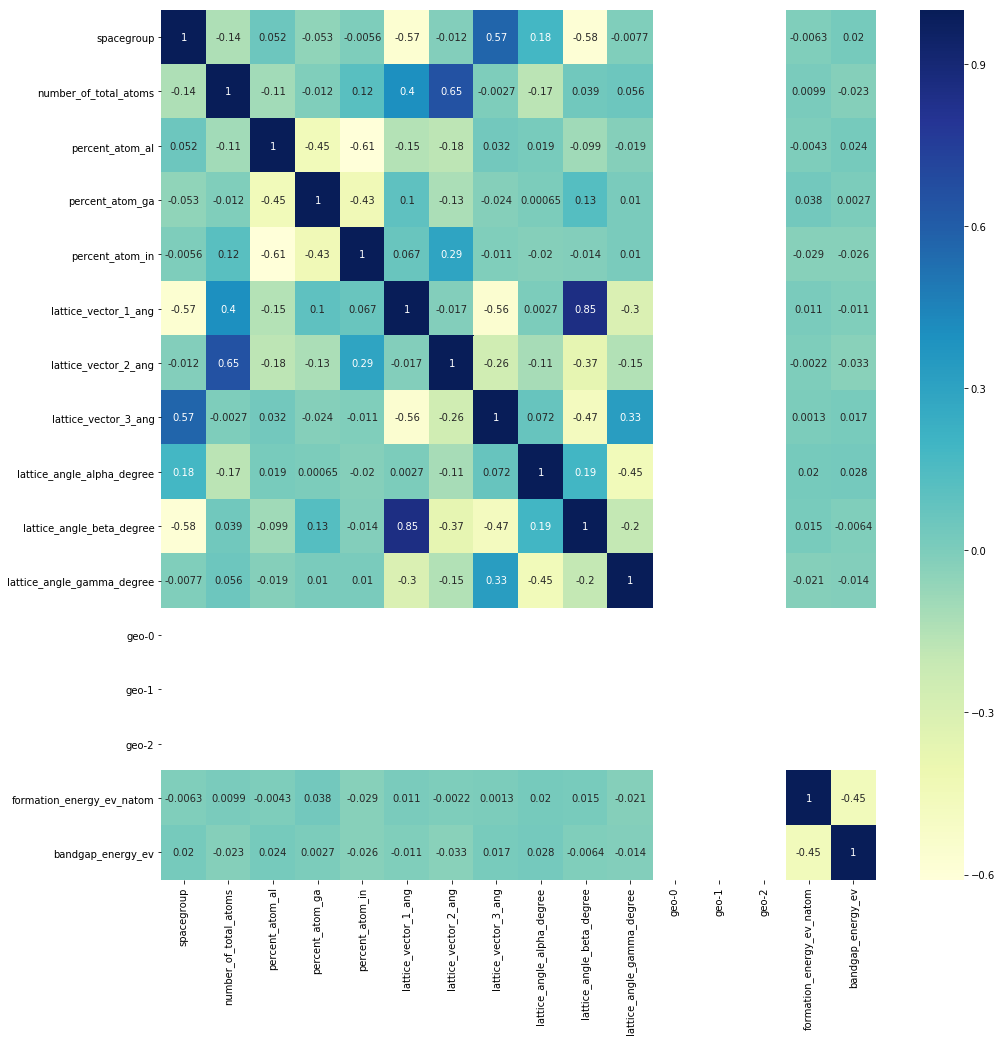

In [162]:
fig = plt.figure(figsize=(16,16))
_ = sns.heatmap(
    corr_matrix, 
    cmap="YlGnBu", 
    annot=True 
)
plt.show()

We should drop geo-1 and geo-2 from the linear regressions.

#### Training Ridge, Lasso, MLP

In [163]:
lrs = np.linspace(0.001, 5, 30)

In [164]:
X = train_data.drop(['geo-1', 'geo-2'], axis=1).values
y = train_labels.values

In [167]:
ridge_losses = []
lasso_losses = []
for lr in lrs:
    ridge = Ridge(alpha=lr)
    lasso = Lasso(alpha=lr)
    ridge_losses.append(cross_val_score(
        ridge, 
        X, 
        y, 
        scoring='neg_mean_squared_log_error', 
        cv=5).mean()
    )
    lasso_losses.append(cross_val_score(
        lasso, 
        X, 
        y, 
        scoring='neg_mean_squared_log_error', 
        cv=5).mean()
    )

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

ValueError: x and y must have same first dimension, but have shapes (30,) and (0,)

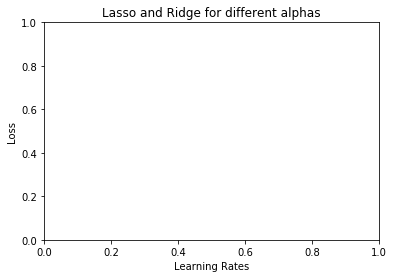

In [166]:
_ = plt.title("Lasso and Ridge for different alphas")
_ = plt.xlabel("Learning Rates")
_ = plt.ylabel("Loss")
_ = plt.plot(lrs, lasso_losses, label="Lasso")
_ = plt.plot(lrs, ridge_losses, label="Ridge")
_ = plt.legend()
plt.show()

##### MLP

In [168]:
from sklearn.neural_network import MLPRegressor

net = MLPRegressor(
    hidden_layer_sizes=(8,), 
    activation = 'relu', 
    solver = 'lbfgs', 
    #momentum=0.99,
    learning_rate='invscaling',
    #random_state=42,
    #batch_size=30, 
    learning_rate_init = 0.001,
    early_stopping=True)

_ = net.fit(train_data, train_labels)

cross_val_score(
        net, 
        X, 
        y, 
        scoring='neg_mean_squared_log_error', 
        cv=5
    ).mean()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

PyTorch MLP

In [169]:
try:
    del dataset
    del dataloader
    del data
    del label
    del labels
except:
    pass
epochs = 200
batch_size = 256
lr = 0.001
input_size = train_data.shape[1]

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2)

class TrainDataset(Dataset):
    def __init__(self, features, labels):
        self.data = features.values
        self.labels = labels.values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def test(m, test_loader):
    m.eval()
    test_loss = 0
    with torch.no_grad():
        for data, label in test_loader:
            preds = m(data.float())
            test_loss += F.mse_loss(preds, label.float()).item()
    return test_loss

train_dataset = TrainDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

test_dataset = TrainDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

In [170]:
model = torch.nn.Sequential(
    torch.nn.Linear(input_size, 10),
    torch.nn.ELU(),
    torch.nn.Linear(10, 2),
    torch.nn.ELU()
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

early_stopping = [INF]
for _ in range(epochs):
    for i, (data, labels) in enumerate(train_dataloader, 0):
        y_pred = model(data.float())
        loss = criterion(y_pred, labels.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    test_loss = test(model, test_dataloader)
    if _ % 5 == 0:
        print("Epoch:\t{}\tTraining Loss:\t{}\tTest Loss:\t{}".format(_, loss.data[0], test_loss))

Epoch:	0	Training Loss:	nan	Test Loss:	nan
Epoch:	5	Training Loss:	nan	Test Loss:	nan
Epoch:	10	Training Loss:	nan	Test Loss:	nan
Epoch:	15	Training Loss:	nan	Test Loss:	nan
Epoch:	20	Training Loss:	nan	Test Loss:	nan
Epoch:	25	Training Loss:	nan	Test Loss:	nan
Epoch:	30	Training Loss:	nan	Test Loss:	nan
Epoch:	35	Training Loss:	nan	Test Loss:	nan
Epoch:	40	Training Loss:	nan	Test Loss:	nan
Epoch:	45	Training Loss:	nan	Test Loss:	nan
Epoch:	50	Training Loss:	nan	Test Loss:	nan
Epoch:	55	Training Loss:	nan	Test Loss:	nan
Epoch:	60	Training Loss:	nan	Test Loss:	nan
Epoch:	65	Training Loss:	nan	Test Loss:	nan
Epoch:	70	Training Loss:	nan	Test Loss:	nan
Epoch:	75	Training Loss:	nan	Test Loss:	nan
Epoch:	80	Training Loss:	nan	Test Loss:	nan
Epoch:	85	Training Loss:	nan	Test Loss:	nan
Epoch:	90	Training Loss:	nan	Test Loss:	nan
Epoch:	95	Training Loss:	nan	Test Loss:	nan
Epoch:	100	Training Loss:	nan	Test Loss:	nan
Epoch:	105	Training Loss:	nan	Test Loss:	nan
Epoch:	110	Training Loss:	nan	Te

#### Submission for MLP

In [171]:
# PyTorch prediction
#_ = model.eval()
#submission_dataset = TrainDataset(test_data, train_labels)
#submission_dataloader = DataLoader(submission_dataset, batch_size=600, shuffle=True, num_workers=8)
#with torch.no_grad():
#    preds = []
#    for data, label in submission_dataloader:
#            preds = model(data.float()).numpy()

In [172]:
# SKLearn pred
preds = net.predict(test_data)

NotFittedError: This MLPRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

The SKLearn MLP regressor did the best overall.

In [ ]:
df = pd.DataFrame((np.arange(600) + 1), columns=['id'])
preds = pd.DataFrame(preds, columns=['formation_energy_ev_natom', 'bandgap_energy_ev'])
submission_df = df.join(preds)
submission_df.to_csv("test_sol.csv", index = False)

#### Submission for Lasso

In [ ]:
_ = lasso.fit(train_data, train_labels)
preds = lasso.predict(test_data)
df = pd.DataFrame((np.arange(600) + 1), columns=['id'])
preds = pd.DataFrame(preds, columns=['formation_energy_ev_natom', 'bandgap_energy_ev'])
preds.to_csv("test_sol.csv", index = False)

#### Submission for Ridge

In [ ]:
_ = ridge.fit(train_data, train_labels)
preds = ridge.predict(test_data)
df = pd.DataFrame((np.arange(600) + 1), columns=['id'])
preds = pd.DataFrame(preds, columns=['formation_energy_ev_natom', 'bandgap_energy_ev'])
preds.to_csv("test_sol.csv", index = False)

I submitted under my personal Kaggle account. After lots of careful debugging, it could not be decided why the Ridge regression did not produce good results. Incorporating the geometric data and scaling was the extent of the feature engineering. Some tuning was attempted with the MLP models, including learning rates and optimizers.

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 
display(Image(url="https://imgur.com/zh27yL3"))

<img src="https://imgur.com/zh27yL3">